# Procjena rizika određenog razmještaja podataka

## Ulazni podaci

Ulaz u algoritam su:

* informacije o raspoloživim pružateljima usluga (engl. cloud providers),
* jedna konkretna raspodjela podataka po pružateljima usluga,
* informacije o važnosti podataka.

In [21]:
# Baza pružatelja usluga računarstva u oblaku s njihovim podacima

# Svaki pružatelj usluga ima reputaciju koja ide u rasponu od 0 do 1 pri čemu je 0 bez ikakve reputacije/nepoznato, 1 apsolutno pouzdan. Raspon je asimptotski podijeljen

cloud_providers = {
    "provider1": {
        "reputation": 0.7
    },
    "provider2": {
        "reputation": 0.6
    },
    "provider3": {
        "reputation": 0.5
    },
    "provider4": {
        "reputation": 0.4
    },
    "provider5": {
        "reputation": 0.1
    }
}

U nastavku slijede različite fragmentacije jedne baze. Vrlo je bitno, zbog kasnije implementacije, da se isto ime ne nalazi u različitim tablicama, odnosno, sva imena kolona u tablicama moraju biti jedinstvena u cijeloj bazi!

In [22]:
# Bez fragmentacije

configuration0 = {
    "radno_mjesto": ["vrsta", "satnica", "norma", "dodatak" ],
    "zaposlenik": ["oib", "vrsta", "broj_sati" ]
}

distribution0 = {
    "provider1": [ "radno_mjesto", "zaposlenik" ]
}

In [23]:
# Fragmenti baze podataka za maksimalnu fragmentaciju i raspodjela po pružateljima usluga

configuration1 = {
    "radno_mjesto_1": ["vrsta", "satnica" ],
    "radno_mjesto_2": ["vrsta", "norma"],
    "radno_mjesto_3": ["vrsta", "dodatak"],
    "zaposlenik_1": ["oib", "vrsta"],
    "zaposlenik_2": ["oib", "broj_sati"],
}

distribution1 = {
    "provider1": [ "radno_mjesto_1" ],
    "provider2": [ "radno_mjesto_2" ],
    "provider3": [ "radno_mjesto_3" ],
    "provider4": [ "zaposlenik_1" ],
    "provider5": [ "zaposlenik_2" ],
}

In [24]:
# Fragmenti baze podataka za jednu fragmentaciju

configuration2 = {
    "radno_mjesto_1": ["vrsta", "satnica", "norma"],
    "radno_mjesto_2": ["vrsta", "dodatak"],
    "zaposlenik": ["oib", "vrsta", "broj_sati"]
}

distribution2 = {
    "provider1": [ "radno_mjesto_1" ],
    "provider2": [ "radno_mjesto_2" ],
    "provider3": [ "zaposlenik" ]
}

In [25]:
# Osjetljivost podataka i njihovih kombinacija. Osjetljivost se mjeri na skali od 0 do 1 pri čemu:
#
# 0 -> apsolutno neosjetljivo, 1 -> apsolutno osjetljivo
# raspodjela u intervalu 0 do 1 nije linearna već asimptotska (komprimiran raspon od 0 do beskonačno)
# osjetljivost - sama po sebi - nije apsolutna već relativna (vrijedi samo za jednu specifičnu konfiguraciju)

# Ovo su za sada konkretne vrijednosti. Trebalo bi razmisliti da se ovdje dozvole rasponi (jer je preciznije definirati raspon), a možda i distribucije

# Još jedna napomena. S obzirom da mi imamo raspon od 0 do 1 i asimptotsku raspodjelu unutar tog raspona, to znači da nakon što
# zbrojim dvije vrijednosti moramo ih propustiti kroz nekakvu funkciju (softmax, tanh ili tako nešto slično).

## IMPLEMENTACIJSKI ZAHTJEVI!!!

# 1. Ovdje treba uzeti u obzir da možemo imati 2**N kombinacija ali nam korisnik već neke kombinacije daje. Te kombinacije koje je
#    dao nemaju linearnu zavisnost (drugim riječima, rizik(a) + rizik(b) < rizik(a,b)). Mi ćemo pretpostaviti da kombinacije koje
#    korisnik nije dao imaju linearnu zavisnost za rizik, tj. treba ih samo zbrojiti!
#
# 2. Ova struktura podataka mora biti sortirana po opadajućem broju elemenata u prvoj listi!!

sensitivity = [

    ({ "oib", "vrsta", "norma", "broj_sati", "dodatak" }, 0.83),  # Napadač zna sve. Ima popis zaposlenika, njihova radna mjesta, plaće, dodatke, određen broj sati
    ({ "oib", "vrsta", "norma", "broj_sati" }, 0.81),              # Malo manje zna, sada ne zna dodatak pa ipak nema potpunu plaću
    ({ "oib", "vrsta", "norma" }, 0.8),                            # Sada napadač može samo odrediti s visokom vjerojatnošću i koliko tko zarađuje
    ({ "oib", "vrsta" }, 0.7),                                     # Napadač saznaje popis zaposlenih, njihovo radno mjesto, popis svih radnih mjesta
    
    # Prvo podaci/kolone samo za sebe
    ({ "vrsta" }, 0.5),        # Saznavši sve vrste, napadač može dobiti raspodjelu radnih mjesta u organizaciji
    ({ "satnica" }, 0.4),      # Na temelju satnice može saznati raspodjelu plaća u organizaciji te vjerojatnost da netko ima određenu plaću
    ({ "norma" }, 0.01),          # Za ovo baš i nisam siguran što bi trebalo značiti???
    ({ "dodatak" }, 0.01),        # Dodatak je?
    ({ "oib" }, 0.6),          # Ako se zna popis OIB-a onda se dobija popis zaposlenika, vrlo osjetljiv podatak
    ({ "broj_sati" }, 0.01),      # (PRETPOSTAVLJAM) radi se o broju odrađenih sati po zaposleniku. Množi se sa normom da se dobije plaća plus dodatak na radno mjesto  

]


## Funkcija za određivanje rizika

Kod određivanja rizika možemo pretpostaviti da se kompromitira cijeli pružatelj usluga odjednom! Dakle, svi podaci na jednom pružatelju usluga kompromitirani su odjednom. 

In [26]:
import math

def determine_risk1(configuration, distribution, sensitivity, cloud_providers):
    
    # Start with no risk at all
    aggregate_risk = 0
    
    # S obzirom da pretpostavljamo kako se svi podaci na pružatelju
    # usluga kompromitiraju odjednom, to znači da trebamo ići po
    # pružateljima usluga te gledati koliko podataka se nalazi na
    # pojedinom pružatelju pri čemu uzimamo u obzir osjetljivost
    # grupe podataka.
    for provider in distribution:
        
        # S obzirom da su sve tablice na jednom provideru zajedno, možemo ih
        # spojiti u jedan skup podataka koji se na pružatelju usluga nalazi i
        # potencijalno je kompromitiran
        columns = set()
        for table in distribution[provider]:
            columns.update(configuration[table])
        
        # Sada kada imamo sve kolone na jednom pružatelju usluga, moramo odrediti koliko su ti
        # podaci kritični. U osnovi, polje "sensitivity" nam to govori, pri čemu mi prvo uzimamo
        # najveći podskup iz "sensitivity" te uklonimo sve kolone koje pripadaju tom podskupu
        # iz columns. Zatim ponavljamo postupak dok nam columns ne ostane prazan skup.
        
        while (len(columns)):
            
            for s in sensitivity:
                
                if s[0] <= columns:
                    
                    aggregate_risk += s[1] ** cloud_providers[provider]["reputation"]
                    columns -= s[0]
            
    return math.tanh(aggregate_risk)

In [27]:
import math

def determine_risk2(configuration, distribution, sensitivity, cloud_providers):
    
    # Start with no risk at all
    aggregate_risk = 0
    
    # S obzirom da pretpostavljamo kako se svi podaci na pružatelju
    # usluga kompromitiraju odjednom, to znači da trebamo ići po
    # pružateljima usluga te gledati koliko podataka se nalazi na
    # pojedinom pružatelju pri čemu uzimamo u obzir osjetljivost
    # grupe podataka.
    for provider in distribution:
        
        # S obzirom da su sve tablice na jednom provideru zajedno, možemo ih
        # spojiti u jedan skup podataka koji se na pružatelju usluga nalazi i
        # potencijalno je kompromitiran
        columns = set()
        for table in distribution[provider]:
            columns.update(configuration[table])
        
        # Sada kada imamo sve kolone na jednom pružatelju usluga, moramo odrediti koliko su ti
        # podaci kritični. U osnovi, polje "sensitivity" nam to govori, pri čemu mi prvo uzimamo
        # najveći podskup iz "sensitivity" te uklonimo sve kolone koje pripadaju tom podskupu
        # iz columns. Zatim ponavljamo postupak dok nam columns ne ostane prazan skup.
        
        while (len(columns)):
            
            for s in sensitivity:
                
                if s[0] <= columns:
                    
                    aggregate_risk += 1 / s[1] ** cloud_providers[provider]["reputation"]
                    columns -= s[0]
            
    return 1 / aggregate_risk

In [28]:
import math

def determine_risk3(configuration, distribution, sensitivity, cloud_providers):
    
    # Start with no risk at all
    aggregate_risk = 0
    
    # S obzirom da pretpostavljamo kako se svi podaci na pružatelju
    # usluga kompromitiraju odjednom, to znači da trebamo ići po
    # pružateljima usluga te gledati koliko podataka se nalazi na
    # pojedinom pružatelju pri čemu uzimamo u obzir osjetljivost
    # grupe podataka.
    for provider in distribution:
        
        # S obzirom da su sve tablice na jednom provideru zajedno, možemo ih
        # spojiti u jedan skup podataka koji se na pružatelju usluga nalazi i
        # potencijalno je kompromitiran
        columns = set()
        for table in distribution[provider]:
            columns.update(configuration[table])
        
        # Sada kada imamo sve kolone na jednom pružatelju usluga, moramo odrediti koliko su ti
        # podaci kritični. U osnovi, polje "sensitivity" nam to govori, pri čemu mi prvo uzimamo
        # najveći podskup iz "sensitivity" te uklonimo sve kolone koje pripadaju tom podskupu
        # iz columns. Zatim ponavljamo postupak dok nam columns ne ostane prazan skup.
        
        while (len(columns)):
            
            for s in sensitivity:
                
                if s[0] <= columns:
                    
                    aggregate_risk += 1 / 10 ** s[1] ** cloud_providers[provider]["reputation"]
                    columns -= s[0]
            
    return 1 / aggregate_risk

In [29]:
import math

def determine_risk4(configuration, distribution, sensitivity, cloud_providers):
    
    # Start with no risk at all
    aggregate_risk = 0
    
    # S obzirom da pretpostavljamo kako se svi podaci na pružatelju
    # usluga kompromitiraju odjednom, to znači da trebamo ići po
    # pružateljima usluga te gledati koliko podataka se nalazi na
    # pojedinom pružatelju pri čemu uzimamo u obzir osjetljivost
    # grupe podataka.
    for provider in distribution:
        
        # S obzirom da su sve tablice na jednom provideru zajedno, možemo ih
        # spojiti u jedan skup podataka koji se na pružatelju usluga nalazi i
        # potencijalno je kompromitiran
        columns = set()
        for table in distribution[provider]:
            columns.update(configuration[table])
        
        # Sada kada imamo sve kolone na jednom pružatelju usluga, moramo odrediti koliko su ti
        # podaci kritični. U osnovi, polje "sensitivity" nam to govori, pri čemu mi prvo uzimamo
        # najveći podskup iz "sensitivity" te uklonimo sve kolone koje pripadaju tom podskupu
        # iz columns. Zatim ponavljamo postupak dok nam columns ne ostane prazan skup.
        
        while (len(columns)):
            
            for s in sensitivity:
                
                if s[0] <= columns:
                    
                    aggregate_risk += 10 ** s[1] ** cloud_providers[provider]["reputation"]
                    columns -= s[0]
            
    return aggregate_risk

In [56]:
def determine_risk5(configuration, distribution, sensitivity, cloud_providers):
    
    # Start with no risk at all
    aggregate_risk = 0
    
    # S obzirom da pretpostavljamo kako se svi podaci na pružatelju
    # usluga kompromitiraju odjednom, to znači da trebamo ići po
    # pružateljima usluga te gledati koliko podataka se nalazi na
    # pojedinom pružatelju pri čemu uzimamo u obzir osjetljivost
    # grupe podataka.
    for provider in distribution:
        
        # S obzirom da su sve tablice na jednom provideru zajedno, možemo ih
        # spojiti u jedan skup podataka koji se na pružatelju usluga nalazi i
        # potencijalno je kompromitiran
        columns = set()
        for table in distribution[provider]:
            columns.update(configuration[table])
        
        # Sada kada imamo sve kolone na jednom pružatelju usluga, moramo odrediti koliko su ti
        # podaci kritični. U osnovi, polje "sensitivity" nam to govori, pri čemu mi prvo uzimamo
        # najveći podskup iz "sensitivity" te uklonimo sve kolone koje pripadaju tom podskupu
        # iz columns. Zatim ponavljamo postupak dok nam columns ne ostane prazan skup.
        
        while (len(columns)):
            
            for s in sensitivity:
                
                if s[0] <= columns:
                    
                    aggregate_risk += (10 ** s[1]) * (math.sin(cloud_providers[provider]["reputation"]*math.pi/2 + math.pi) + 1)
                    columns -= s[0]
            
    return aggregate_risk

In [63]:
def determine_risk6(configuration, distribution, sensitivity, cloud_providers):
    
    # Start with no risk at all
    aggregate_risk = 0
    
    # S obzirom da pretpostavljamo kako se svi podaci na pružatelju
    # usluga kompromitiraju odjednom, to znači da trebamo ići po
    # pružateljima usluga te gledati koliko podataka se nalazi na
    # pojedinom pružatelju pri čemu uzimamo u obzir osjetljivost
    # grupe podataka.
    for provider in distribution:
        
        # S obzirom da su sve tablice na jednom provideru zajedno, možemo ih
        # spojiti u jedan skup podataka koji se na pružatelju usluga nalazi i
        # potencijalno je kompromitiran
        columns = set()
        for table in distribution[provider]:
            columns.update(configuration[table])
        
        # Sada kada imamo sve kolone na jednom pružatelju usluga, moramo odrediti koliko su ti
        # podaci kritični. U osnovi, polje "sensitivity" nam to govori, pri čemu mi prvo uzimamo
        # najveći podskup iz "sensitivity" te uklonimo sve kolone koje pripadaju tom podskupu
        # iz columns. Zatim ponavljamo postupak dok nam columns ne ostane prazan skup.
        
        while (len(columns)):
            
            for s in sensitivity:
                
                if s[0] <= columns:
                    
                    aggregate_risk += (1)/((10 ** s[1]) * (math.sin(cloud_providers[provider]["reputation"]*math.pi/2 + math.pi) + 1))
                    columns -= s[0]
            
    return 1/aggregate_risk

## Eksperimenti nad ulaznim podacima

### Slučaj 1: Svi podaci na jednom pružatelju usluga.

Rizik ovdje ovisi samo o pouzdanosti pružatelja usluga na kojemu su podaci smješteni. Prema tome, ako se variraju pružatelji usluga, rizik se mora mijenjati.

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline  

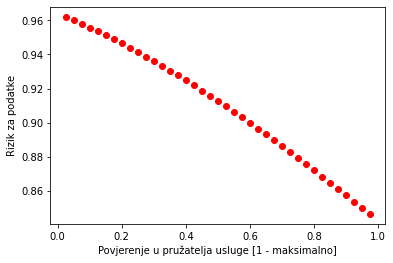

In [31]:
# Određivanje rizika kada su podaci na jednom pružatelju usluga

STEPS=40

x = []
y = []
for r in range(1,STEPS):
    x.append(r/STEPS)
    y.append(determine_risk1(configuration0, distribution0, sensitivity, { "provider1": { "reputation": r/STEPS } }))
    
plt.plot(x,y,'ro')
plt.xlabel("Povjerenje u pružatelja usluge [1 - maksimalno]")
plt.ylabel("Rizik za podatke")
plt.show()

Funkcija ima dobar trend, rizik se smanjuje kako povjerenje u pružatelja usluge raste. Međutim, kada se apsolutno vjeruje pružatelju usluge, tada bi rizik trebao biti nula ili vrlo blizu nule - što u ovom slučaju nije.

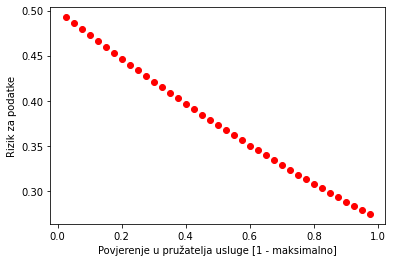

In [32]:
# Određivanje rizika kada su podaci na jednom pružatelju usluga

STEPS=40

x = []
y = []
for r in range(1,STEPS):
    x.append(r/STEPS)
    y.append(determine_risk2(configuration0, distribution0, sensitivity, { "provider1": { "reputation": r/STEPS } }))
    
plt.plot(x,y,'ro')
plt.xlabel("Povjerenje u pružatelja usluge [1 - maksimalno]")
plt.ylabel("Rizik za podatke")
plt.show()

#### Komentar na graf funkcije

Funkcija ima dobar trend, kako raste povjerenje u pružatelja usluge tako i opada rizik za podatke. Međutim, kako povjerenje u pružatelja usluge pada tako bi rizik za podatke trebao biti bliži jedinici!

In [33]:
# Određivanje rizika kada su podaci svaki na svom pružatelju usluga

print(determine_risk2(configuration1, distribution1, sensitivity, cloud_providers))

# Određivanje rizika kada su podaci na dva pružatelju usluga

print(determine_risk2(configuration2, distribution2, sensitivity, cloud_providers))

0.02770607798207826
0.017481786826165188


Rizik je u slučaju kada se koristi manje pružatelja usluga manji! Što se čini pogrešnim. Međutim, ne mora nužno biti jer jako ovisi kako su osjetljivi podaci raspodijeljeni. Moguće je da su za manji broj pružatelja usluga korišteni kvalitetniji pružatelji usluga, dok u slučaju većeg broja pružatelja usluga podaci završe na osjetljivijem mjestu.

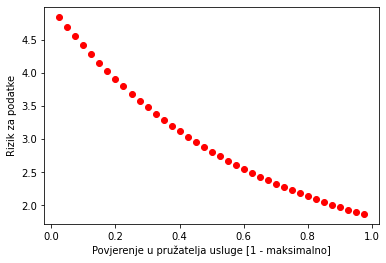

In [34]:
# Određivanje rizika kada su podaci na jednom pružatelju usluga

STEPS=40

x = []
y = []
for r in range(1,STEPS):
    x.append(r/STEPS)
    y.append(determine_risk3(configuration0, distribution0, sensitivity, { "provider1": { "reputation": r/STEPS } }))
    
plt.plot(x,y,'ro')
plt.xlabel("Povjerenje u pružatelja usluge [1 - maksimalno]")
plt.ylabel("Rizik za podatke")
plt.show()



### Komentar na graf funkcije

Funkcija ima dobar trend. Minimum i maksimum funkcije su losi (minimum bi trebao biti blize 0, a maksimum blize jedinici).


In [67]:
# Određivanje rizika kada su podaci svaki na svom pružatelju usluga

print(determine_risk3(configuration1, distribution1, sensitivity, cloud_providers))

# Određivanje rizika kada su podaci na dva pružatelju usluga

print(determine_risk3(configuration2, distribution2, sensitivity, cloud_providers))

0.3229991666642562
0.2876962535722074


Rezultati slicni proslima, razlika medu njima je manja. Koja funkcija ima bolje ponasanje ovisi o odnosu koji se uzima izmedu reputacije pruzatelja usluge i osjetljivosti podataka. Ova funkcija i gornja se razlikuju u tome sto gornja ima vise povjerenja u reputaciju pruzatelja usluge.

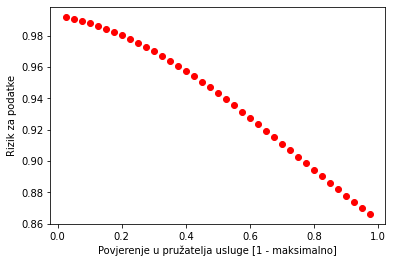

In [35]:
# Određivanje rizika kada su podaci na jednom pružatelju usluga
def sigmoid(x):  
    return 1/(1 + np.exp(-x))


STEPS=40

x = []
y = []
for r in range(1,STEPS):
    x.append(r/STEPS)
    y.append(sigmoid(determine_risk3(configuration0, distribution0, sensitivity, { "provider1": { "reputation": r/STEPS } })))
    
plt.plot(x,y,'ro')
plt.xlabel("Povjerenje u pružatelja usluge [1 - maksimalno]")
plt.ylabel("Rizik za podatke")
plt.show()


### Komentar na graf funkcije

Funkcija ima dobar trend, i dobar maksimum, medutim minimum, odnosno raspon, rizika je los. 

In [69]:
# Određivanje rizika kada su podaci svaki na svom pružatelju usluga

print(sigmoid(determine_risk3(configuration1, distribution1, sensitivity, cloud_providers)))

# Određivanje rizika kada su podaci na dva pružatelju usluga

print(sigmoid(determine_risk3(configuration2, distribution2, sensitivity, cloud_providers)))

0.580054997650535
0.5714320443525049


Funkcija je slicna kao prethodne dvije osim u tome sto su rizici slicniji (blize jedan drugome).

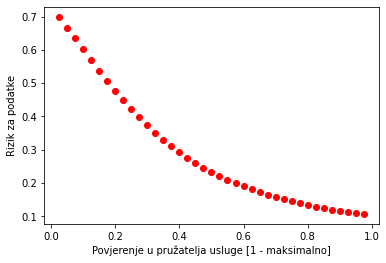

In [36]:

def altered_sigmoid(x):  
    return 1/(1 + np.exp(-x + 4))

STEPS=40

x = []
y = []
for r in range(1,STEPS):
    x.append(r/STEPS)
    y.append(altered_sigmoid(determine_risk3(configuration0, distribution0, sensitivity, { "provider1": { "reputation": r/STEPS } })))
    
plt.plot(x,y,'ro')
plt.xlabel("Povjerenje u pružatelja usluge [1 - maksimalno]")
plt.ylabel("Rizik za podatke")
plt.show()

### Komentar na graf funkcije

Promijenjena sigmoidalna funkcija ima dobar trend. Minimumi i maksimumi su bolji nego kod prethodnih funkcija.

In [70]:
# Određivanje rizika kada su podaci svaki na svom pružatelju usluga

print(altered_sigmoid(determine_risk3(configuration1, distribution1, sensitivity, cloud_providers)))

# Određivanje rizika kada su podaci na dva pružatelju usluga

print(altered_sigmoid(determine_risk3(configuration2, distribution2, sensitivity, cloud_providers)))

0.024674502560876135
0.023839020719981226


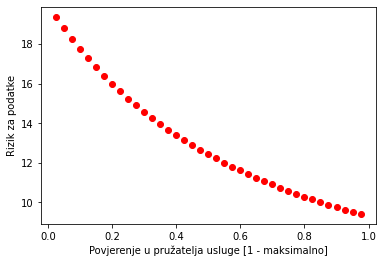

In [65]:
import numpy as np

def altered_sigmoid(x):  
    return 1/(1 + np.exp(-x + 4))

STEPS=40

x = []
y = []
for r in range(1,STEPS):
    x.append(r/STEPS)
    y.append(determine_risk4(configuration0, distribution0, sensitivity, { "provider1": { "reputation": r/STEPS } }))
    
plt.plot(x,y,'ro')
plt.xlabel("Povjerenje u pružatelja usluge [1 - maksimalno]")
plt.ylabel("Rizik za podatke")
plt.show()

### Komentar na graf funkcije

Funkcija ima dobar trend, minimum i maksimum su se malo oteli kontroli.

In [71]:
# Određivanje rizika kada su podaci svaki na svom pružatelju usluga

print(determine_risk4(configuration1, distribution1, sensitivity, cloud_providers))

# Određivanje rizika kada su podaci na dva pružatelju usluga

print(determine_risk4(configuration2, distribution2, sensitivity, cloud_providers))

40.12078806292869
22.432955376803715


Funkcija za razliku od prethodnih radi vecu razliku izmedu dvije konfiguracije. Vidi se favoriziranje konfiguracije u kojoj su podaci odijeljeni.

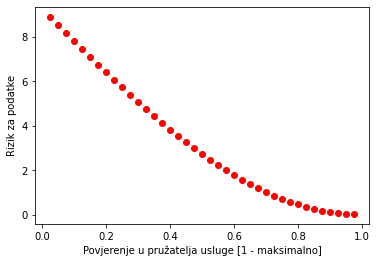

In [72]:
STEPS=40

x = []
y = []
for r in range(1,STEPS):
    x.append(r/STEPS)
    y.append(determine_risk5(configuration0, distribution0, sensitivity, { "provider1": { "reputation": r/STEPS } }))
    
plt.plot(x,y,'ro')
plt.xlabel("Povjerenje u pružatelja usluge [1 - maksimalno]")
plt.ylabel("Rizik za podatke")
plt.show()

### Komentar na graf funkcije

Funkcija ima dobar trend, dobar minimum, ali maksimum se cini prevelik. 


In [73]:
# Određivanje rizika kada su podaci svaki na svom pružatelju usluga

print(determine_risk5(configuration1, distribution1, sensitivity, cloud_providers))

# Određivanje rizika kada su podaci na dva pružatelju usluga

print(determine_risk5(configuration2, distribution2, sensitivity, cloud_providers))

8.931222265190932
3.2970109892920223


Iz prilozenog izgleda da funkcija puno vise vrednuje odvojenost podataka od povjerenja u pruzatelja usluge.

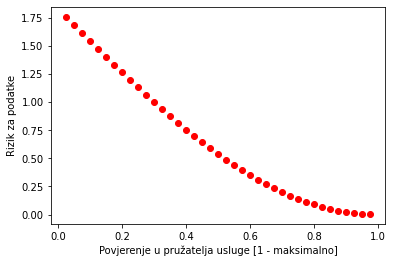

In [64]:
def n(val):
    return 1.0-(1/val)

x = []
y = []
for r in range(1,STEPS):
    x.append(r/STEPS)
    y.append(determine_risk6(configuration0, distribution0, sensitivity, { "provider1": { "reputation": r/STEPS } }))
    
plt.plot(x,y,'ro')
plt.xlabel("Povjerenje u pružatelja usluge [1 - maksimalno]")
plt.ylabel("Rizik za podatke")
plt.show()

In [ ]:
### Komentar na graf funkcije

Funkcija izgleda jednako kao funkcija prije, osim sto ima manji maksimum.

In [74]:
# Određivanje rizika kada su podaci svaki na svom pružatelju usluga

print(determine_risk6(configuration1, distribution1, sensitivity, cloud_providers))

# Određivanje rizika kada su podaci na dva pružatelju usluga

print(determine_risk6(configuration2, distribution2, sensitivity, cloud_providers))

0.050805198144167875
0.03800788236833702


Funkcija radi manju razliku izmedu konfiguracija od prijasnje funkcije.

## Dodatak A - ponašanje funkcija

### Ponašanje funkcije rizika: osjetljivost^reputacija_pružatelja_usluge

osjetljivost je iz intervala [0, 1]
reputacija_pružatelja_usluge je iz intervala [0, 1]


Nužno ponašanje funkcije je da za iste osjetljivosti daje veći izlaz ako je reputacija_pruzatelja_usluge manja. Sljedeći grafovi pokazuju ponašanje funkcije ako je osjetljivost konstantna.

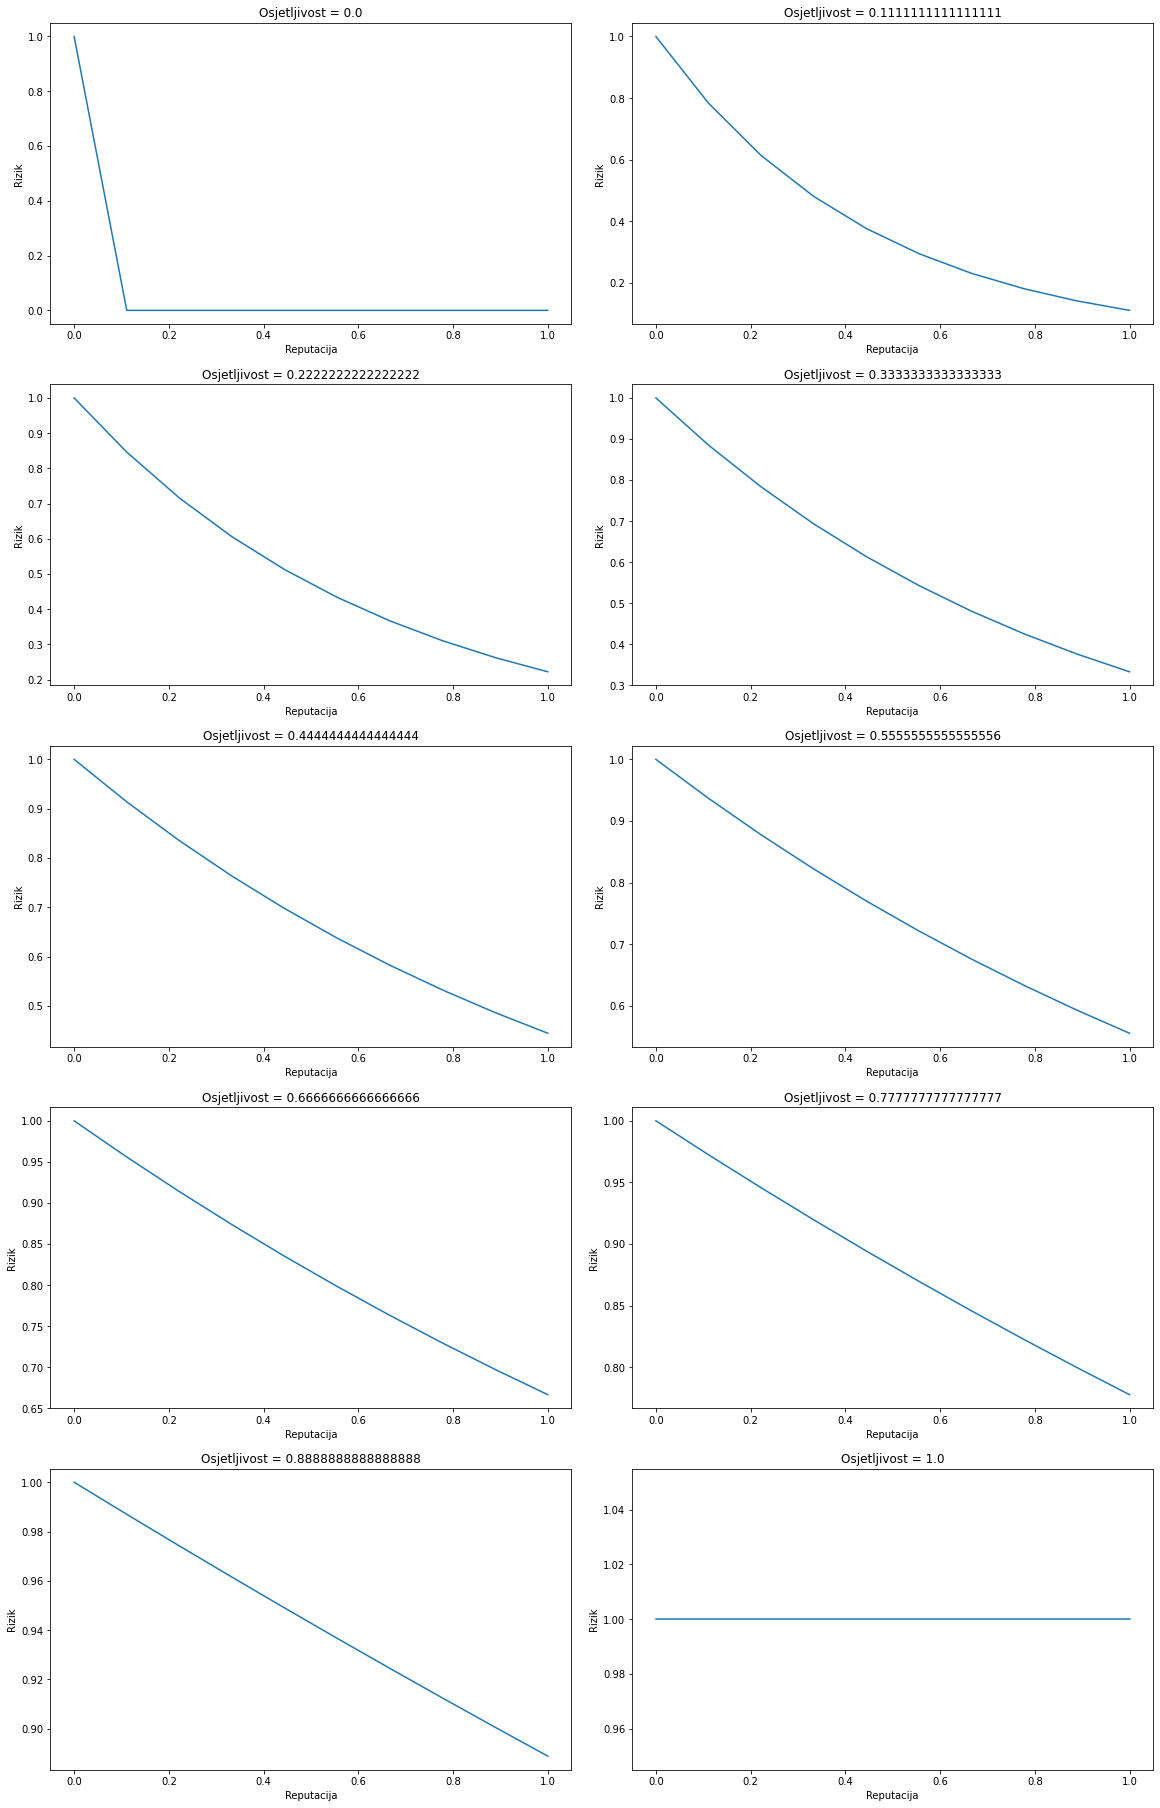

In [38]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure

from collections import defaultdict

def show_risk_sensitivity_reputation_relationship_graph(rep_const=1.0):


    sensitivities = np.linspace(0.0, 1.0, 10, endpoint=True)
    reputations = np.linspace(0.0, 1.0, 10, endpoint=True)

    risk = defaultdict(dict)

    for sensitivity in sensitivities:
        for reputation in reputations:
            risk[sensitivity][reputation] = sensitivity**(rep_const*reputation)

    fig, axs = plt.subplots(nrows=5, ncols=2, constrained_layout=True, figsize=(16,25))

    for i, ax in enumerate(axs.flat):
        ax.plot(reputations, [risk[sensitivities[i]][rep] for rep in reputations])
        ax.set_xlabel('Reputacija')
        ax.set_ylabel('Rizik')
        ax.set_title(f'Osjetljivost = {sensitivities[i]}')


show_risk_sensitivity_reputation_relationship_graph()

Iz grafova se moze vidjeti da se rizik nejednoliko smanjuje sto je reputacija veca. Sto je osjetljivost veca to krivulja sve vise nalikuje na pravac. Isto tako, sto je osjetljivost veca to je minimum za rizik veci. Ovo sve spada pod ocekivano ponasanje za funkciju rizika no mozda se krivulja zeli vise naglasiti u smislu manjeg rizika gdje je pruzatelj usluge bolji.

Slijede grafovi s razlicitom konstantom koja mnozi reputaciju.

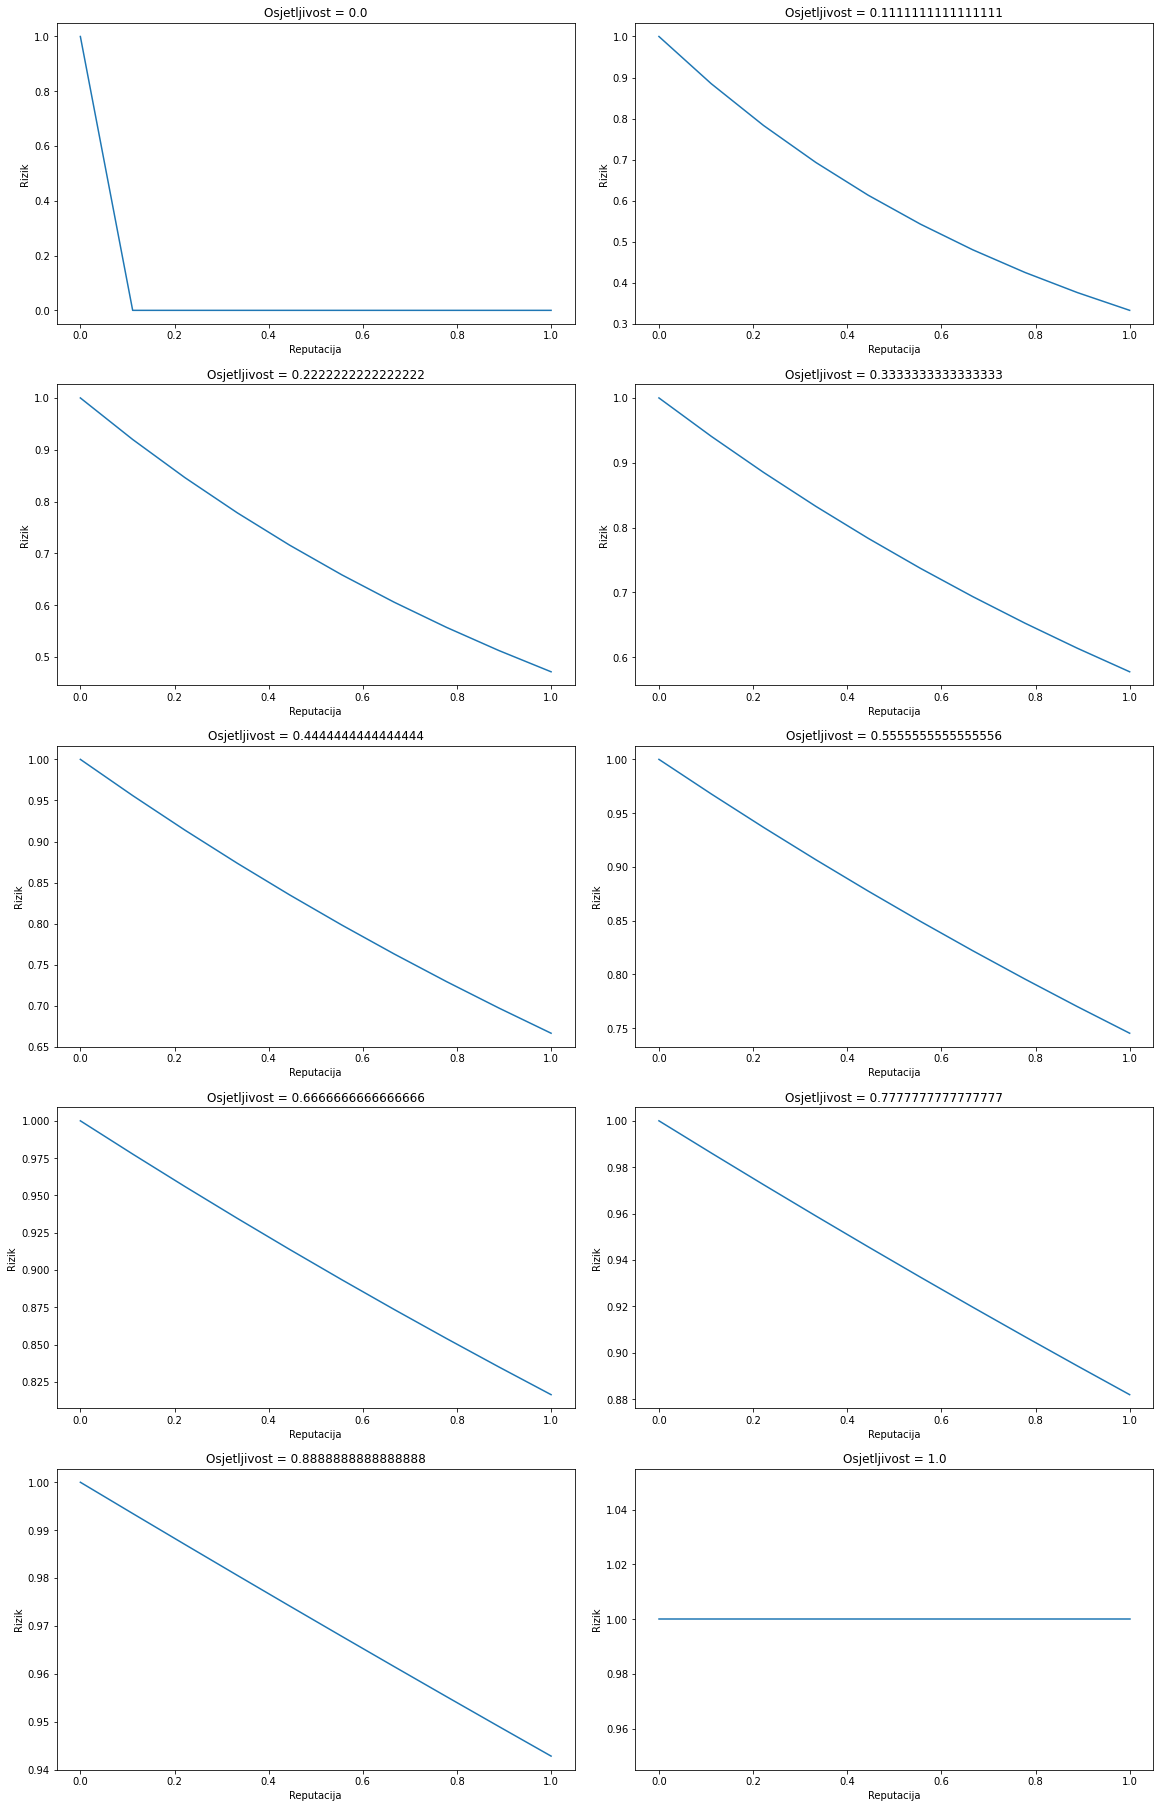

In [39]:
show_risk_sensitivity_reputation_relationship_graph(rep_const=0.5)

Uz manju konstantu krivulja za manje osjetljivosti postaje pravac.

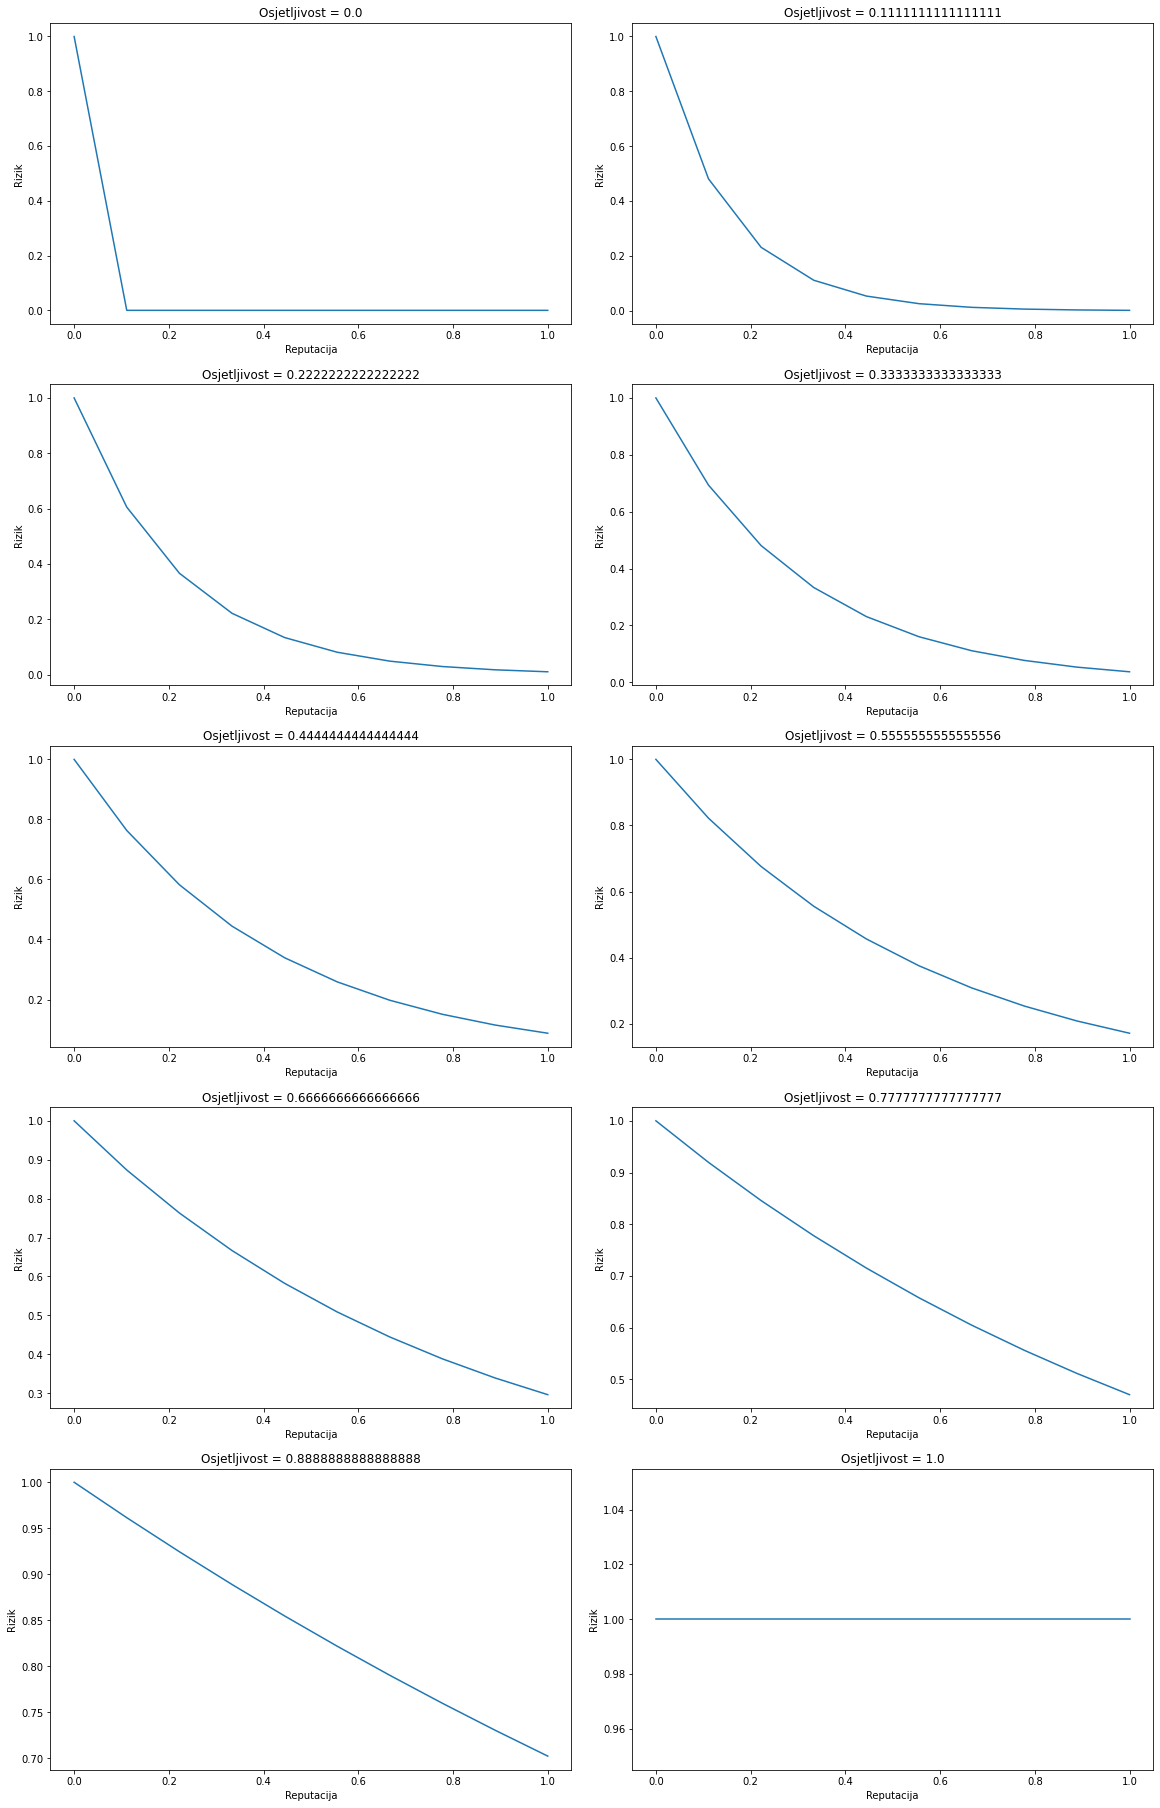

In [40]:
show_risk_sensitivity_reputation_relationship_graph(rep_const=3)

Uz vecu konstantu rizik je veci u slucajevima da manje vjerujemo pruzatelju usluge.

Na svim grafovima može se primjetiti da ako pružatelj usluge ima reputaciju 0 (nimalo pouzdan, ili nema podataka) neovisno o osjetljivosti podataka rizik je 1.

Isto tako, promatramo li slučaj kada je osjetljivost 1, funkcija se ponaša kao pravac paralelan s x-osi u svim slučajevima. 
Prema ovoj formuli to znači da je svejedno gdje će se smjestiti osjetljivi podaci (tj. podaci koji su sadržani u najvažnijem sigurnosnom zahtjevu).




### Ponašanje funkcije rizika: osjetljivost * (1/(reputacija_pružatelja_usluge + const))

Drugi pokušaj modeliranja funkcije rizika koji pokušava rješiti loše strane prvoga.



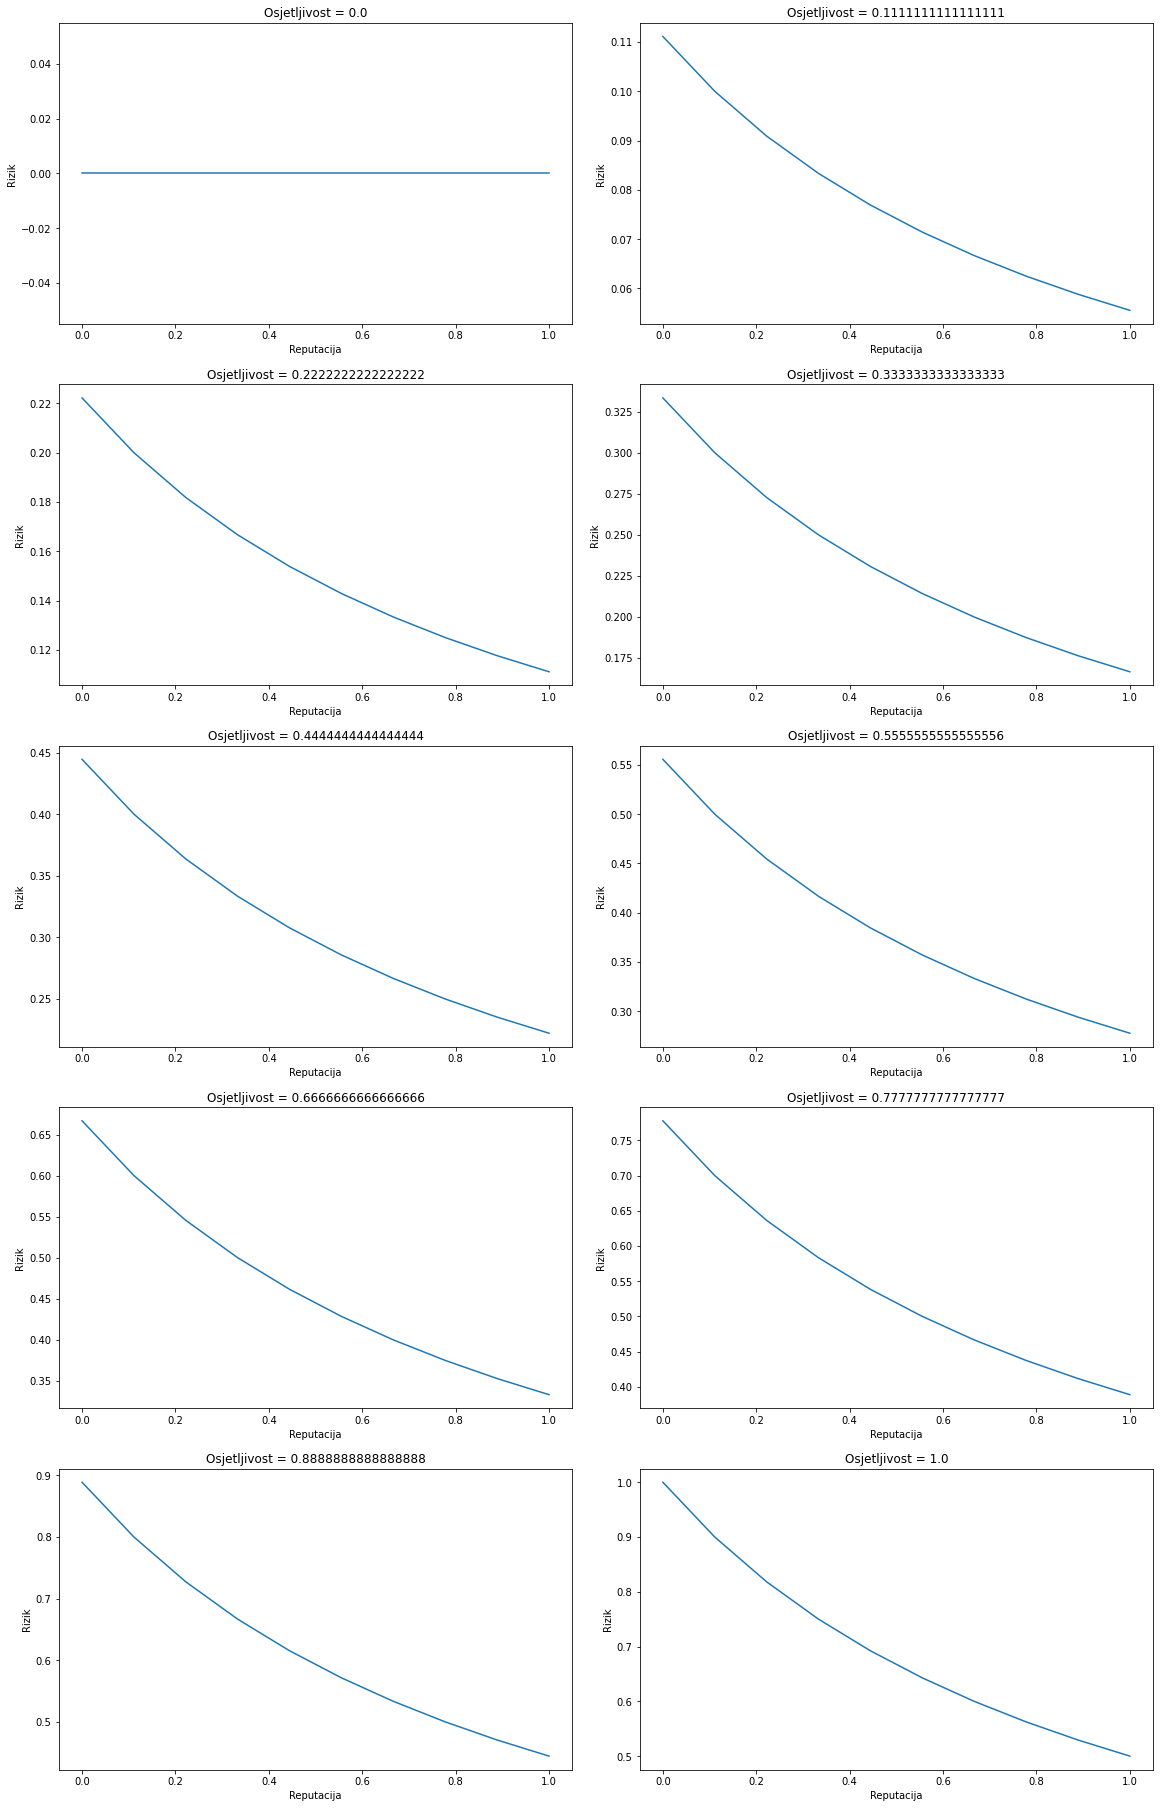

In [41]:
def show_risk_sensitivity_reputation_relationship_graph2(rep_const=1.0):


    sensitivities = np.linspace(0.0, 1.0, 10, endpoint=True)
    reputations = np.linspace(0.0, 1.0, 10, endpoint=True)

    risk = defaultdict(dict)

    for sensitivity in sensitivities:
        for reputation in reputations:
            risk[sensitivity][reputation] = sensitivity*(1/(rep_const+reputation))

    fig, axs = plt.subplots(nrows=5, ncols=2, constrained_layout=True, figsize=(16,25))

    for i, ax in enumerate(axs.flat):
        ax.plot(reputations, [risk[sensitivities[i]][rep] for rep in reputations])
        ax.set_xlabel('Reputacija')
        ax.set_ylabel('Rizik')
        ax.set_title(f'Osjetljivost = {sensitivities[i]}')

show_risk_sensitivity_reputation_relationship_graph2()

Pogledamo li krivulju, možemo uočiti da za slučaj kada je osjetljivost 0 imamo pravac po x-osi. Ovo je očekivano ponašanje - ako podaci nisu osjetljivi i stavimo ih na bilo kojeg pružatelja usluge (neovisno o njegovoj reputaciji) rizik ostaje jednak.

U svim drugim slučajevima maksimalni iznos rizika je iznos osjetljivosti sigurnosnog zahtjeva koji se narušio.

Funkcija ima problem s minimalnim iznosom rizika koji se može postići. Kada je reputacija pružatelja usluge 1 (najveća moguća - pružatelju usluge apsolutno vjerujemo) imamo rizik od 0.5, a intuitivno bi bilo da je rizik 0.

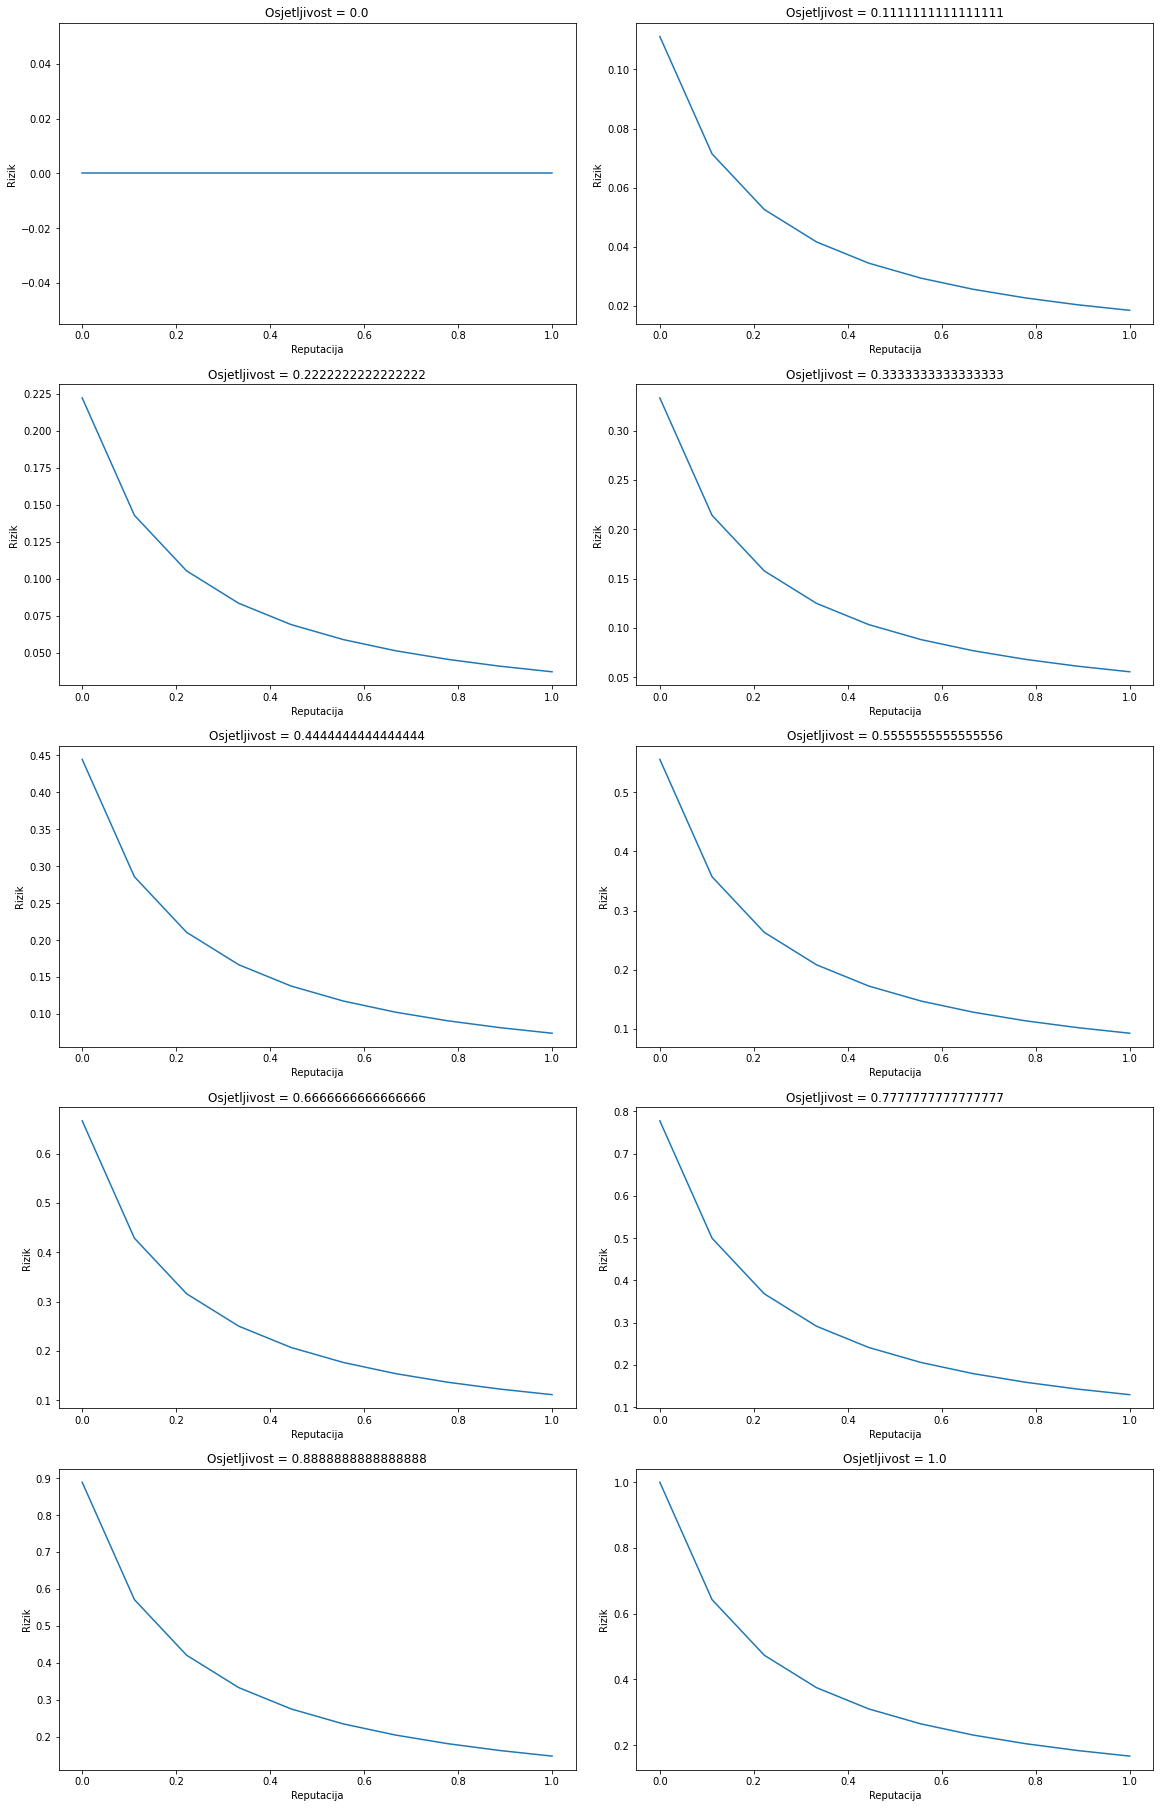

In [52]:
def show_risk_sensitivity_reputation_relationship_graph3(rep_const=1.0):


    sensitivities = np.linspace(0.0, 1.0, 10, endpoint=True)
    reputations = np.linspace(0.0, 1.0, 10, endpoint=True)

    risk = defaultdict(dict)

    for sensitivity in sensitivities:
        for reputation in reputations:
            risk[sensitivity][reputation] = sensitivity*(1/(rep_const+5*reputation))

    fig, axs = plt.subplots(nrows=5, ncols=2, constrained_layout=True, figsize=(16,25))

    for i, ax in enumerate(axs.flat):
        ax.plot(reputations, [risk[sensitivities[i]][rep] for rep in reputations])
        ax.set_xlabel('Reputacija')
        ax.set_ylabel('Rizik')
        ax.set_title(f'Osjetljivost = {sensitivities[i]}')

show_risk_sensitivity_reputation_relationship_graph3()

Pomnožimo li reputaciju s konstantom vecom od 1, dobivamo da nas graf sadrži veći dio funkcije 1/x, međutim razlike između rizika susjednih reputacija u grafu (primjerice 0.4 i 0.6) postaju sve više naglašene ako se radi o prvom dijelu grafa, a sve manje ukoliko se radi o drugom dijelu grafa.
Uz to, funkcija rizika nikada neće doseči 0.

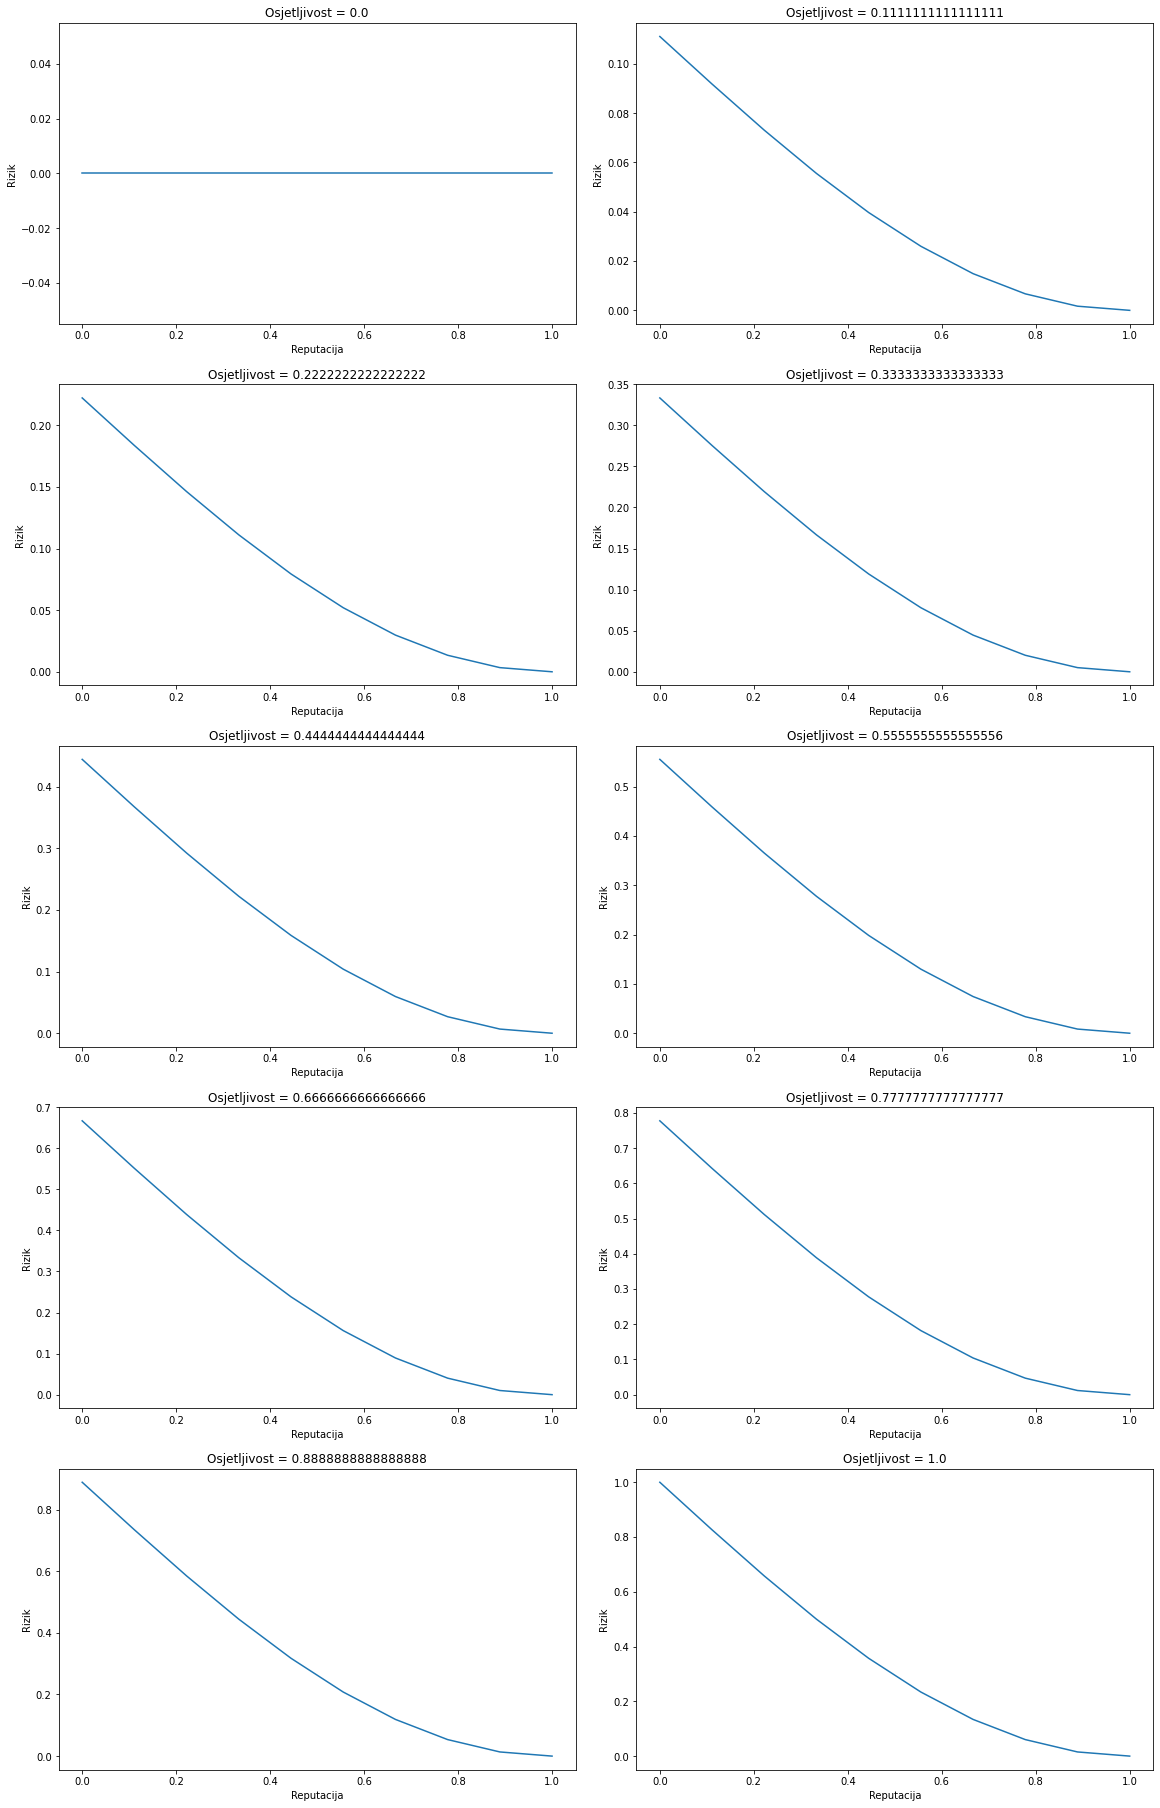

In [51]:
def show_risk_sensitivity_reputation_relationship_graph4(rep_const=1.0):


    sensitivities = np.linspace(0.0, 1.0, 10, endpoint=True)
    reputations = np.linspace(0.0, 1.0, 10, endpoint=True)

    risk = defaultdict(dict)

    for sensitivity in sensitivities:
        for reputation in reputations:
            risk[sensitivity][reputation] = sensitivity* (math.sin(reputation*math.pi/2 + math.pi) + 1)

    fig, axs = plt.subplots(nrows=5, ncols=2, constrained_layout=True, figsize=(16,25))

    for i, ax in enumerate(axs.flat):
        ax.plot(reputations, [risk[sensitivities[i]][rep] for rep in reputations])
        ax.set_xlabel('Reputacija')
        ax.set_ylabel('Rizik')
        ax.set_title(f'Osjetljivost = {sensitivities[i]}')

show_risk_sensitivity_reputation_relationship_graph4()

Promotrimo li funkciju sinus, ona se sastoji od 4 dijela u kojima se funkcija različito ponaša. 
Obzirom da je reputacija sigurno u intervalu od 0 do 1, to možemo skalirati s pi/2 kako bi dobili cijelo poducje jednog od 4 dijela funkcije. 
Odabir jednog od 4 dijela moze se napraviti zbrajanjem.
Dodatak jedinice na rezultat funkcije sinus radi se kako bi koeficijent na kraju bio pozitivan.

Funkcija zadržava sva pozitivna svojstva funkcija nabrojanih prije, no od njih se razlikuje u tome što doseže rizik od 0 kada se reputacija pružatelja usluge približava jedinici i linearno pada u prvom dijelu funkcije.